In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name = fn, length = len(uploaded[fn])))

Saving archive.zip to archive.zip
User uploaded file "archive.zip" with length 63252113 bytes


In [ ]:
from zipfile import ZipFile
file_name = "archive.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
train_dir = 'train'
val_dir = 'test'
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 28709 images belonging to 7 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(train_dir,
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(val_dir,
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

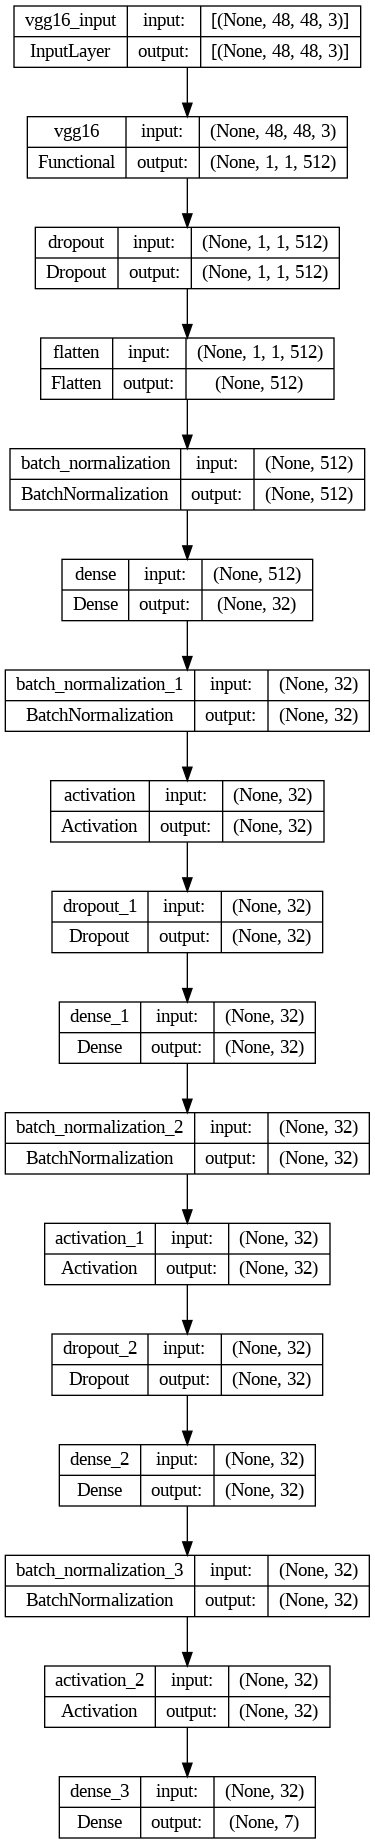

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 30,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/30
449/449 [==============================] - 42s 53ms/step - loss: 1.9424 - accuracy: 0.8541 - precision: 0.2319 - recall: 0.0092 - auc: 0.5981 - f1_score: 0.0172 - val_loss: 1.8089 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6497 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/30
449/449 [==============================] - 21s 46ms/step - loss: 1.7779 - accuracy: 0.8599 - precision: 0.6322 - recall: 0.0454 - auc: 0.6634 - f1_score: 0.0838 - val_loss: 1.7420 - val_accuracy: 0.8610 - val_precision: 0.9231 - val_recall: 0.0293 - val_auc: 0.6874 - val_f1_score: 0.0559 - lr: 0.0010
Epoch 3/30
449/449 [==============================] - 19s 42ms/step - loss: 1.6806 - accuracy: 0.8667 - precision: 0.7354 - recall: 0.1050 - auc: 0.7137 - f1_score: 0.1830 - val_loss: 1.6116 - val_accuracy: 0.8719 - val_precision: 0.8685 - val_recall: 0.1219 - val_auc: 0.7440 - val_f1_score: 0.2117 - lr: 0.0010
Epoch 4/30
449/449 [=============================

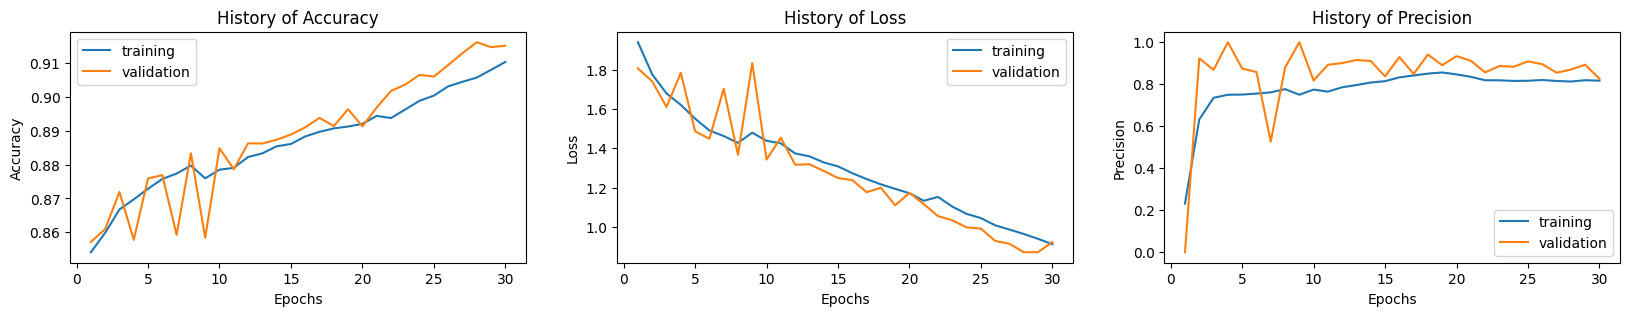

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,precision,val_precision):
    
    fig, (ax1, ax2,ax4) = plt.subplots(1,3, figsize= (20,3))

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['precision'],history.history['val_precision']
              )

113/113 [==============================] - 9s 70ms/step


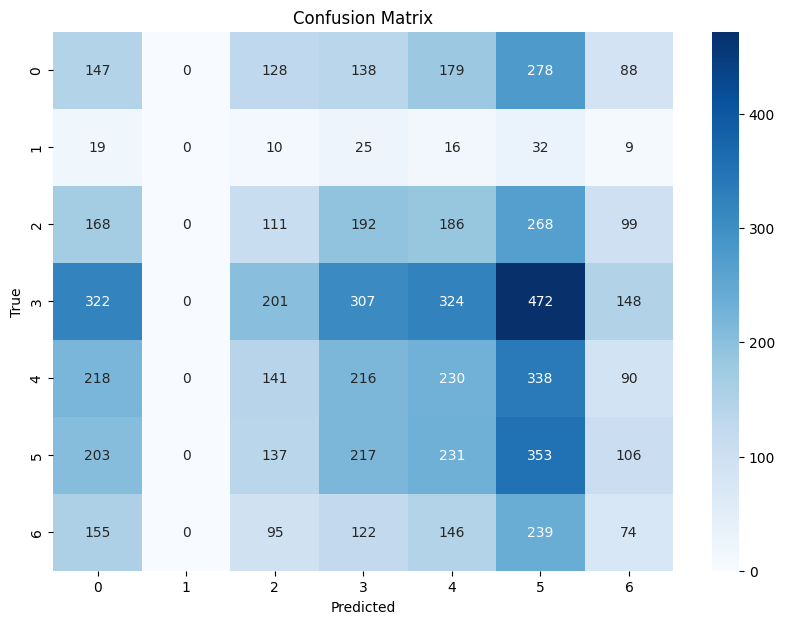

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

# Generate predictions for the test dataset
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true = test_dataset.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

2/2 [==============================] - 0s 15ms/step


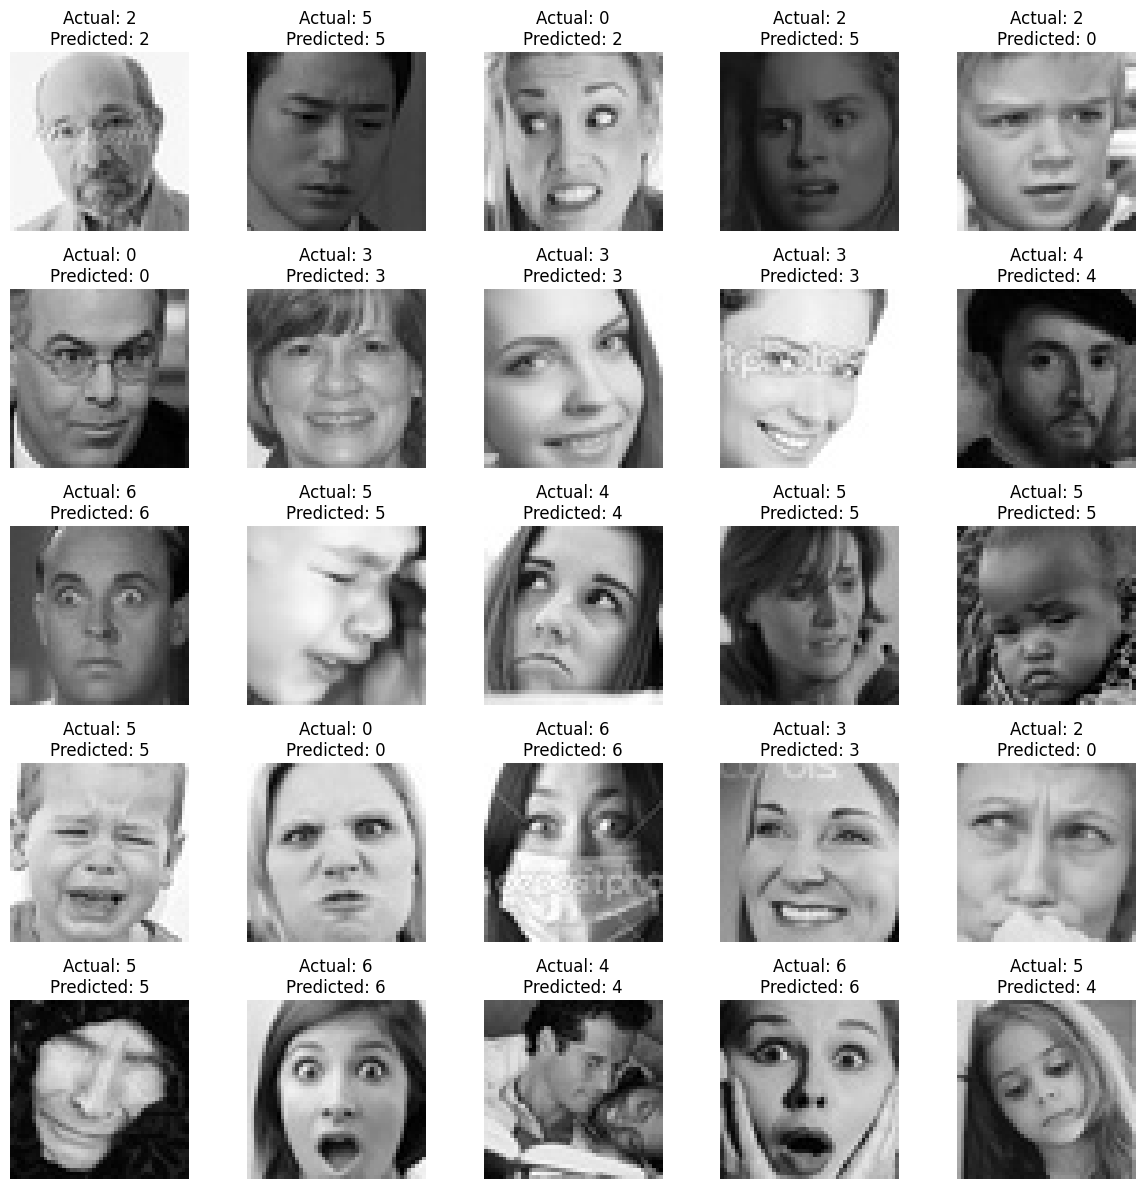

In [ ]:
#Images from training dataset

import numpy as np
import matplotlib.pyplot as plt

# Define the number of rows and columns for the grid
num_rows = 5
num_cols = 5

# Select a batch of images from the training dataset
images, labels = next(iter(train_dataset))

# Make predictions using the trained model
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Create the grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Iterate over the grid of subplots
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j

        # Get the actual label and predicted label for the image
        actual_label = np.argmax(labels[index])
        predicted_label = predicted_labels[index]

        # Display the image with its actual and predicted values
        axs[i, j].imshow(images[index])
        axs[i, j].axis('off')
        axs[i, j].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=12)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the grid of images
plt.show()

2/2 [==============================] - 0s 17ms/step


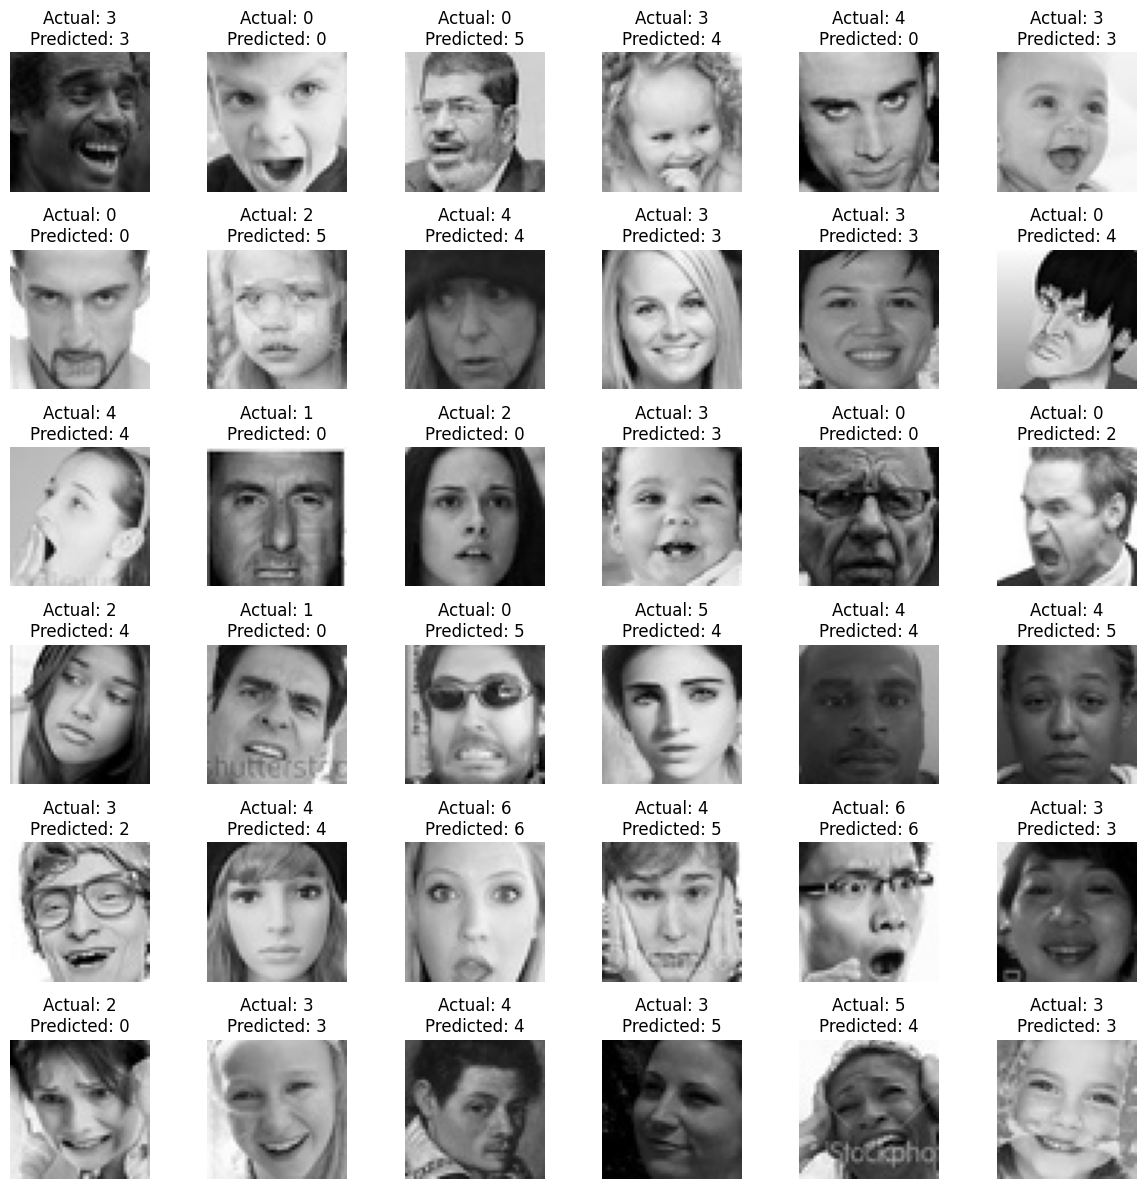

In [ ]:
#Testing

import numpy as np
import matplotlib.pyplot as plt

# Define the number of rows and columns for the grid
num_rows = 6
num_cols = 6

# Get a batch of images and labels from the test dataset
images, labels = next(iter(test_dataset))

# Make predictions using the trained model
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Create the grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Iterate over the grid of subplots
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j

        # Get the actual label and predicted label for the image
        actual_label = np.argmax(labels[index])
        predicted_label = predicted_labels[index]

        # Display the image with its actual and predicted values
        axs[i, j].imshow(images[index])
        axs[i, j].axis('off')
        axs[i, j].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=12)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the grid of images
plt.show()


In [ ]:
model.save('my_model.h5')